In [1]:
import os
from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt

In [5]:
DATA_ROOT = Path(r"C:\Users\USER\Documents\Health_Tech_Initiative\archive (32)\cell_images_data") 
train_dir = DATA_ROOT / "train"
val_dir   = DATA_ROOT / "val"

In [6]:
# Import params

img_size = 180
batch_size = 32
seed = 42
AUTOTUNE = tf.data.AUTOTUNE

initial_epochs = 8
fine_tune_epochs = 12

In [7]:
# quick existence checks
assert train_dir.exists(), f"{train_dir} not found"
assert val_dir.exists(), f"{val_dir} not found"
print("Train folder:", train_dir)
print("Val folder:  ", val_dir)

Train folder: C:\Users\USER\Documents\Health_Tech_Initiative\archive (32)\cell_images_data\train
Val folder:   C:\Users\USER\Documents\Health_Tech_Initiative\archive (32)\cell_images_data\val


In [14]:
#load datasets (labels inferred from subfolders; label_mode=int -> 0/1)

train_ds = image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    image_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)

Found 22046 files belonging to 2 classes.


In [15]:
val_ds = image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="int",
    image_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=False
)

Found 5512 files belonging to 2 classes.


In [16]:
print("Class names (index -> label):", train_ds.class_names)

Class names (index -> label): ['parasitized', 'uninfected']


In [17]:
# 2) sanity counts (sampleed)
def collect_counts(ds, max_batches=200):
    labels=[]
    for i, (_, y) in enumerate(ds):
        labels.append(y.numpy().ravel())
        if i+1 >= max_batches: break
    labels = np.concatenate(labels)
    print("unique:", np.unique(labels), "counts (sampled):", np.bincount(labels.astype(int)))
    return labels

_ = collect_counts(train_ds, max_batches=200)
_ = collect_counts(val_ds,   max_batches=200)


unique: [0 1] counts (sampled): [3246 3154]
unique: [0 1] counts (sampled): [2756 2756]


In [18]:
# 3) augmentation (training-only)

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
])

In [19]:
# 4) preprocessing for EfficientNetB0
# image_dataset_from_directory returns uint8 [0,255]. EfficientNet preprocess_input expects float in [0,255].
preprocess_fn = tf.keras.applications.efficientnet.preprocess_input

def prep_train(x, y):
    x = tf.cast(x, tf.float32)  # make sure float32
    x = preprocess_fn(x)        # EfficientNet preprocessing
    x = data_augmentation(x)    # augmentation AFTER preprocess is OK (augmentation operates on floats)
    return x, y

def prep_val(x, y):
    x = tf.cast(x, tf.float32)
    x = preprocess_fn(x)
    return x, y

train_ds = train_ds.map(prep_train, num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)
val_ds   = val_ds.map(prep_val,   num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)

In [20]:
# 5) build model (EfficientNetB0 base + small head)
base_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(img_size,img_size,3), pooling="avg")
base_model.trainable = False

inputs = keras.Input(shape=(img_size, img_size, 3))
x = base_model(inputs, training=False)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 1280)                │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [21]:
#6) compile for head training

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc"), keras.metrics.Precision(name="precision"), keras.metrics.Recall(name="recall")]
)

In [22]:
# 7) callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("best_effnetb0.h5", monitor="val_auc", mode="max", save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-7),
    keras.callbacks.EarlyStopping(monitor="val_auc", patience=6, restore_best_weights=True)
]

In [23]:
# 8) train head
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs,
    callbacks=callbacks
)

Epoch 1/8
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - accuracy: 0.8012 - auc: 0.8795 - loss: 0.4254 - precision: 0.8051 - recall: 0.7758

689/689 ━━━━━━━━━━━━━━━━━━━━ 632s 891ms/step - accuracy: 0.8013 - auc: 0.8796 - loss: 0.4252 - precision: 0.8052 - recall: 0.7759 - val_accuracy: 0.9213 - val_auc: 0.9731 - val_loss: 0.2090 - val_precision: 0.9265 - val_recall: 0.9151 - learning_rate: 1.0000e-04
Epoch 2/8
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 0.9038 - auc: 0.9643 - loss: 0.2417 - precision: 0.8976 - recall: 0.9081

689/689 ━━━━━━━━━━━━━━━━━━━━ 552s 802ms/step - accuracy: 0.9038 - auc: 0.9643 - loss: 0.2417 - precision: 0.8976 - recall: 0.9081 - val_accuracy: 0.9318 - val_auc: 0.9770 - val_loss: 0.1880 - val_precision: 0.9334 - val_recall: 0.9300 - learning_rate: 1.0000e-04
Epoch 3/8
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.9128 - auc: 0.9688 - loss: 0.2244 - precision: 0.9053 - recall: 0.9188

689/689 ━━━━━━━━━━━━━━━━━━━━ 523s 759ms/step - accuracy: 0.9128 - auc: 0.9688 - loss: 0.2244 - precision: 0.9053 - recall: 0.9188 - val_accuracy: 0.9351 - val_auc: 0.9780 - val_loss: 0.1840 - val_precision: 0.9366 - val_recall: 0.9332 - learning_rate: 1.0000e-04
Epoch 4/8
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.9200 - auc: 0.9729 - loss: 0.2087 - precision: 0.9131 - recall: 0.9257

689/689 ━━━━━━━━━━━━━━━━━━━━ 513s 744ms/step - accuracy: 0.9200 - auc: 0.9729 - loss: 0.2087 - precision: 0.9131 - recall: 0.9257 - val_accuracy: 0.9363 - val_auc: 0.9794 - val_loss: 0.1783 - val_precision: 0.9381 - val_recall: 0.9343 - learning_rate: 1.0000e-04
Epoch 5/8
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.9245 - auc: 0.9748 - loss: 0.2004 - precision: 0.9230 - recall: 0.9238

689/689 ━━━━━━━━━━━━━━━━━━━━ 516s 748ms/step - accuracy: 0.9245 - auc: 0.9748 - loss: 0.2004 - precision: 0.9230 - recall: 0.9238 - val_accuracy: 0.9381 - val_auc: 0.9803 - val_loss: 0.1735 - val_precision: 0.9377 - val_recall: 0.9387 - learning_rate: 1.0000e-04
Epoch 6/8
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.9222 - auc: 0.9753 - loss: 0.1994 - precision: 0.9172 - recall: 0.9258

689/689 ━━━━━━━━━━━━━━━━━━━━ 509s 739ms/step - accuracy: 0.9222 - auc: 0.9753 - loss: 0.1994 - precision: 0.9172 - recall: 0.9258 - val_accuracy: 0.9396 - val_auc: 0.9807 - val_loss: 0.1716 - val_precision: 0.9369 - val_recall: 0.9427 - learning_rate: 1.0000e-04
Epoch 7/8
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.9265 - auc: 0.9755 - loss: 0.1965 - precision: 0.9204 - recall: 0.9310

689/689 ━━━━━━━━━━━━━━━━━━━━ 510s 741ms/step - accuracy: 0.9265 - auc: 0.9755 - loss: 0.1965 - precision: 0.9204 - recall: 0.9310 - val_accuracy: 0.9385 - val_auc: 0.9810 - val_loss: 0.1703 - val_precision: 0.9371 - val_recall: 0.9401 - learning_rate: 1.0000e-04
Epoch 8/8
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.9278 - auc: 0.9780 - loss: 0.1877 - precision: 0.9228 - recall: 0.9316

689/689 ━━━━━━━━━━━━━━━━━━━━ 513s 744ms/step - accuracy: 0.9278 - auc: 0.9780 - loss: 0.1877 - precision: 0.9228 - recall: 0.9316 - val_accuracy: 0.9376 - val_auc: 0.9813 - val_loss: 0.1730 - val_precision: 0.9414 - val_recall: 0.9332 - learning_rate: 1.0000e-04


In [24]:
# 9) fine-tune: unfreeze top layers of base
base_model.trainable = True
# Freeze lower layers, unfreeze the top N layers for fine-tuning
fine_tune_at = len(base_model.layers) - 50  # adjust if needed
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

In [25]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc"), keras.metrics.Precision(name="precision"), keras.metrics.Recall(name="recall")]
)

In [26]:
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=fine_tune_epochs,
    callbacks=callbacks
)

Epoch 1/12
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9042 - auc: 0.9641 - loss: 0.2442 - precision: 0.9046 - recall: 0.8996

689/689 ━━━━━━━━━━━━━━━━━━━━ 850s 1s/step - accuracy: 0.9042 - auc: 0.9641 - loss: 0.2442 - precision: 0.9046 - recall: 0.8996 - val_accuracy: 0.9445 - val_auc: 0.9837 - val_loss: 0.1623 - val_precision: 0.9271 - val_recall: 0.9648 - learning_rate: 1.0000e-05
Epoch 2/12
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.9360 - auc: 0.9812 - loss: 0.1728 - precision: 0.9238 - recall: 0.9483

689/689 ━━━━━━━━━━━━━━━━━━━━ 599s 870ms/step - accuracy: 0.9360 - auc: 0.9812 - loss: 0.1728 - precision: 0.9238 - recall: 0.9483 - val_accuracy: 0.9487 - val_auc: 0.9861 - val_loss: 0.1505 - val_precision: 0.9340 - val_recall: 0.9655 - learning_rate: 1.0000e-05
Epoch 3/12
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 909ms/step - accuracy: 0.9454 - auc: 0.9869 - loss: 0.1427 - precision: 0.9325 - recall: 0.9584

689/689 ━━━━━━━━━━━━━━━━━━━━ 742s 1s/step - accuracy: 0.9454 - auc: 0.9869 - loss: 0.1427 - precision: 0.9325 - recall: 0.9584 - val_accuracy: 0.9514 - val_auc: 0.9887 - val_loss: 0.1377 - val_precision: 0.9390 - val_recall: 0.9655 - learning_rate: 1.0000e-05
Epoch 5/12
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 904ms/step - accuracy: 0.9495 - auc: 0.9887 - loss: 0.1316 - precision: 0.9377 - recall: 0.9612

689/689 ━━━━━━━━━━━━━━━━━━━━ 753s 1s/step - accuracy: 0.9495 - auc: 0.9887 - loss: 0.1316 - precision: 0.9377 - recall: 0.9612 - val_accuracy: 0.9528 - val_auc: 0.9893 - val_loss: 0.1333 - val_precision: 0.9401 - val_recall: 0.9673 - learning_rate: 1.0000e-05
Epoch 6/12
689/689 ━━━━━━━━━━━━━━━━━━━━ 636s 924ms/step - accuracy: 0.9647 - auc: 0.9935 - loss: 0.0970 - precision: 0.9555 - recall: 0.9737 - val_accuracy: 0.9561 - val_auc: 0.9897 - val_loss: 0.1262 - val_precision: 0.9454 - val_recall: 0.9681 - learning_rate: 1.0000e-05
Epoch 11/12
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - accuracy: 0.9658 - auc: 0.9942 - loss: 0.0931 - precision: 0.9556 - recall: 0.9759

689/689 ━━━━━━━━━━━━━━━━━━━━ 636s 923ms/step - accuracy: 0.9658 - auc: 0.9942 - loss: 0.0931 - precision: 0.9556 - recall: 0.9759 - val_accuracy: 0.9574 - val_auc: 0.9903 - val_loss: 0.1231 - val_precision: 0.9465 - val_recall: 0.9695 - learning_rate: 1.0000e-05
Epoch 12/12
689/689 ━━━━━━━━━━━━━━━━━━━━ 610s 886ms/step - accuracy: 0.9657 - auc: 0.9950 - loss: 0.0871 - precision: 0.9576 - recall: 0.9735 - val_accuracy: 0.9574 - val_auc: 0.9902 - val_loss: 0.1244 - val_precision: 0.9478 - val_recall: 0.9681 - learning_rate: 1.0000e-05


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

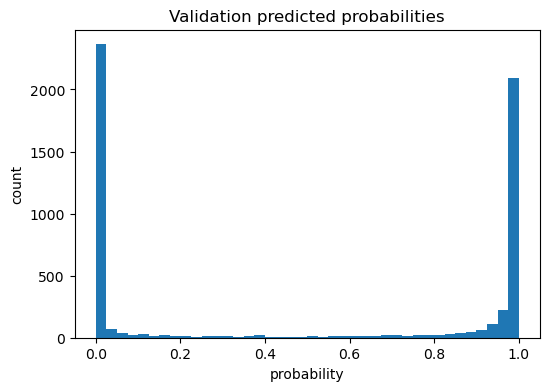

In [28]:
# 10) Final evaluation & diagnostics
y_true = []
y_probs = []
for x_batch, y_batch in val_ds:
    y_true.append(y_batch.numpy().ravel())
    y_probs.append(model.predict(x_batch).ravel())
y_true = np.concatenate(y_true)
y_probs = np.concatenate(y_probs)
y_pred = (y_probs > 0.5).astype(int)

print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification report:\n", classification_report(y_true, y_pred, digits=4))
print("ROC AUC:", roc_auc_score(y_true, y_probs))

plt.figure(figsize=(6,4))
plt.hist(y_probs, bins=40)
plt.title("Validation predicted probabilities")
plt.xlabel("probability")
plt.ylabel("count")
plt.show()

In [42]:
from tensorflow.keras.preprocessing import image

img_path = r"C:\Users\USER\Documents\Health_Tech_Initiative\archive (32)\cell_images_data\train\parasitized\C39P4thinF_original_IMG_20150622_105102_cell_96.png"

# Load & preprocess Image
img = image.load_img(img_path, target_size =(180,180))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis =0)/255.0

# Predict
pred = model.predict(img_array)

# For binary classification
prob = pred[0][0]
label = "Parasitized" if prob>0.5 else "Uninfected"

print("Prediction Probability.:", prob)
print("Predicted Class.:", label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Prediction Probability.: 0.57917994
Predicted Class.: Parasitized


In [38]:
from pathlib import Path

train_dir = Path(r'C:\Users\USER\Documents\Health_Tech_Initiative\archive (32)\cell_images_data\train')   # <-- update to your actual train folder
class_names = sorted([p.name for p in train_dir.iterdir() if p.is_dir()])
print("class_names (index -> label):", list(enumerate(class_names)))
# Example output: [(0,'parasitized'), (1,'uninfected')]


class_names (index -> label): [(0, 'parasitized'), (1, 'uninfected')]


In [43]:
# 11) Save final model (best one already saved by ModelCheckpoint)
model.save("finalfinal_effnetb0_model.h5")
print("Saved final model to final_effnetb0_model.h5")

Saved final model to final_effnetb0_model.h5
